<a href="https://colab.research.google.com/github/lbdlab/NGS-LBD/blob/master/notebooks/NGS_LBD_Prioritization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NGS-LBD Prioritization
Experiments with NGS-LBD prioritization

In [1]:
pip install neo4j pandas seaborn matplotlib

     |████████████████████████████████| 81kB 8.5MB/s 
  Created wheel for neo4j: filename=neo4j-4.3.1-cp37-none-any.whl size=99332 sha256=e995c97e7ddd0f718e2b8dd5d2a0c949cbb10f8978385dd53d1b30e4f852b482
  Stored in directory: /root/.cache/pip/wheels/23/13/72/0cc2405898bd9a7baef6512df3abf83873da9ba48c04acc818
Successfully built neo4j


In [2]:
%matplotlib inline
from neo4j import GraphDatabase
import pandas as pd
import seaborn as sns
from matplotlib import pyplot

sns.set(font_scale = 1.5)

In [3]:
# Connect to Neo4j
driver = GraphDatabase.driver('neo4j://212.235.239.171:22333', auth=('neo4j', 'ngslbd2020'))

def read_query(query, params={}):
    with driver.session(database="semmed43cord19") as session:
        result = session.run(query, params)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

In [4]:
%load_ext google.colab.data_table

## Prioritization User Story 

### Make a list of all patients
Later, add a field `status` (with values: `open` and `closed`) to `Patient` nodes.

In [5]:
patients = read_query("""
  match (p:Patient) return p.patient_id limit 100
""")

pat_list = patients["p.patient_id"].to_list()

### Select a patient with a particular `patient_id`

In [15]:
import ipywidgets as widgets
selected_patient = widgets.Dropdown(
    options=pat_list, # ['1', '2', '3'],
    #value='',
    description='Patient:',
    disabled=False,
)
selected_patient


Dropdown(description='Patient:', options=('DUMMY_RX6651', 'DUMMY_RX8300', 'DUMMY_RX9350', 'DUMMY_RX5846', 'DUM…

In [16]:
#@title Select a patient
patient_id = 'DUMMY_RX8007' #@param {type:"string"}
patient_list = 'DUMMY_RX9350' #@param pat_list
pat_id = "DUMMY_RX6651"

#read_query(f"""
#  match (p:Patient) where p.patient_id='{patient_list}' return p.patient_id limit 100
#""")
read_query("""
  match (p:Patient) where p.patient_id=$selected_patient return p.patient_id limit 100
""", {'selected_patient': selected_patient.value})

,p.patient_id
0,DUMMY_RX9350


## Prioritization Algorithm

In [7]:
# Query for filtering and ranking Phenotype - Genotype existing relations
read_query("""
  match (c1)<-[:PHENO_UMLS]-(p:Patient)-[r:GENO]->(g) 
  where (r.HMZinSLO < 2) AND (r.GnomADHMZ < 10) 
  with c1,p,r,g 
  match (c1)-[r2]-(g) 
  return c1.cui,c1.name,labels(c1),type(r),r.freq,type(r2),r2.freq,g.cui,g.name,labels(g) 
  order by r2.freq desc, r.functional_impact_num desc, 
  r.GnomADAlleleCount asc, r.ExACGeneralMAF asc, r.HTZinSLO asc, r.UK10KAlleleCount asc, r.cadd_score desc, r.SIFT asc limit 20
  """)


,c1.cui,c1.name,labels(c1),type(r),r.freq,type(r2),r2.freq,g.cui,g.name,labels(g)
0,C0026848,Myopathy,"[dsyn, Concept]",GENO,None,CAUSES,1,4621,MYH3,"[Concept, gngm, aapp]"


In [9]:
# Query for filtering and ranking Phenotype - Genetype existing relations - direct and indirect relations
read_query("""
  match (c1)<-[:PHENO_UMLS]-(p:Patient)-[r:GENO]->(g) 
  where (r.HMZinSLO < 2) AND (r.GnomADHMZ < 10) 
  with c1,p,r,g 
  match (c1)-[r2]-(g) 
  with c1,r,p,r2,g 
  order by r2.freq desc, r.functional_impact_num desc, r.GnomADAlleleCount asc, r.ExACGeneralMAF asc, r.HTZinSLO asc, r.UK10KAlleleCount asc, 
    r.cadd_score desc, r.SIFT asc limit 10 
  match (c1)<-[r3]-(c2)<-[r4]-(g) 
  return c1.cui,c1.name,type(r3),r3.freq,c2.cui,c2.name,labels(c2),type(r4),r4.freq,g.cui,g.name 
  order by r3.freq+r4.freq desc limit 20
  """)

,c1.cui,c1.name,type(r3),r3.freq,c2.cui,c2.name,labels(c2),type(r4),r4.freq,g.cui,g.name
0,C0026848,Myopathy,CAUSES,404,C0026882,Mutation,"[Concept, genf]",AFFECTS,1,4621,MYH3
1,C0026848,Myopathy,CAUSES,404,C0026882,Mutation,"[Concept, genf]",LOCATION_OF,1,4621,MYH3
2,C0026848,Myopathy,ISA,11,C0003886,Arthrogryposis,"[dsyn, Concept, cgab]",AFFECTS,1,4621,MYH3
3,C0026848,Myopathy,ASSOCIATED_WITH,7,C0208355,multicatalytic endopeptidase complex,"[Concept, gngm, aapp, enzy]",INTERACTS_WITH,1,4621,MYH3
4,C0026848,Myopathy,NEG_CAUSES,5,C0026882,Mutation,"[Concept, genf]",AFFECTS,1,4621,MYH3
5,C0026848,Myopathy,NEG_CAUSES,5,C0026882,Mutation,"[Concept, genf]",LOCATION_OF,1,4621,MYH3
6,C0026848,Myopathy,AFFECTS,4,C0026882,Mutation,"[Concept, genf]",AFFECTS,1,4621,MYH3
7,C0026848,Myopathy,AFFECTS,4,C0026882,Mutation,"[Concept, genf]",LOCATION_OF,1,4621,MYH3
8,C0026848,Myopathy,ASSOCIATED_WITH,2,C0000934,Acclimatization,"[Concept, orgf]",AFFECTS,1,4621,MYH3
9,C0026848,Myopathy,AFFECTS,2,C0040690,Transforming Growth Factor beta,"[Concept, gngm, aapp, bacs]",INTERACTS_WITH,1,4621,MYH3




---


From this point on are examples by Tomaz Bratanic for inspiration

---




In [ ]:
read_query("""
  match (c:Concept) return c.cui,c.name,labels(c) limit 10000
""")

,c.cui,c.name,labels(c)
0,C3828416,Radiation Damage,"[dsyn, Concept]"
1,C1068401,Malus xiaojinensis,"[Concept, plnt]"
2,C1142446,Bicytopenia,"[Concept, lbtr]"
3,C0057485,Deriphat,"[Concept, phsu, orch]"
4,C1142447,Granulomatous myositis,"[dsyn, Concept]"
...,...,...,...
9995,C1071182,Camellia nitidissima,"[Concept, plnt]"
9996,C0294037,acridine mustard,"[Concept, phsu, orch]"
9997,C2239784|79576,NKAP gene|NKAP,"[Concept, gngm]"
9998,C1063680,Crioceris asparagi,"[Concept, invt]"


In [ ]:
# Infer similarity network between drugs based on TREATS relationship
read_query("""
CALL apoc.periodic.iterate(
"MATCH (p1:phsu)-[r1:TREATS]->(:dsyn)<-[r2:TREATS]-(p2:phsu)
WHERE id(p1) > id(p2) AND r1.freq > 1 AND r2.freq > 1
RETURN p1,p2",
"MERGE (p1)-[t:SIMILAR_NEW]-(p2) ON CREATE SET t.weight = 1 ON MATCH SET t.weight = t.weight + 1",
{batchSize:10000})
""")

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-3-380d45ff30a2>, line 8)

In [ ]:
# Potential drug repurposing

read_query("""
MATCH (c:Concept{name:"Atrial Fibrillation"})<-[t:TREATS]-(existing)
WITH c,existing, t.freq as frequency
ORDER BY frequency DESC LIMIT 5
MATCH (existing)-[r:SIMILAR_NEW]-(potential)
WHERE NOT (potential)-[:TREATS]->(c)
WITH potential, sum(r.weight) as total_weight
ORDER BY total_weight
DESC LIMIT 10
RETURN potential.name as potential
""")

,potential
0,glucose
1,melatonin
2,Anesthetics
3,vitamin E
4,Steroids
5,cyclophosphamide
6,arginine
7,dexamethasone
8,iron
9,simvastatin


In [ ]:
def find_potential_drugs(disease):
  query = """
  MATCH (c:Concept{name:$disease})<-[t:TREATS]-(existing)
  WITH c,existing, t.freq as frequency
  ORDER BY frequency DESC LIMIT 5
  MATCH (existing)-[r:SIMILAR_NEW]-(potential)
  WHERE NOT (potential)-[:TREATS]->(c)
  WITH potential, sum(r.weight) as total_weight
  ORDER BY total_weight
  DESC LIMIT 10
  RETURN potential.name as potential
  """
  with driver.session() as session:
    result = session.run(query, {'disease':disease})
    return pd.DataFrame([r.values() for r in result], columns=result.keys())



In [ ]:
find_potential_drugs('Headache')

,potential


In [ ]:
read_query("""
MATCH (u:phsu)
RETURN count(*) as total_nodes,
       sum(CASE WHEN (u)-[:SIMILAR_NEW]-() THEN 1 END) as nodes_with_similar_relationships
""")

,total_nodes,nodes_with_similar_relationships
0,27395,7548


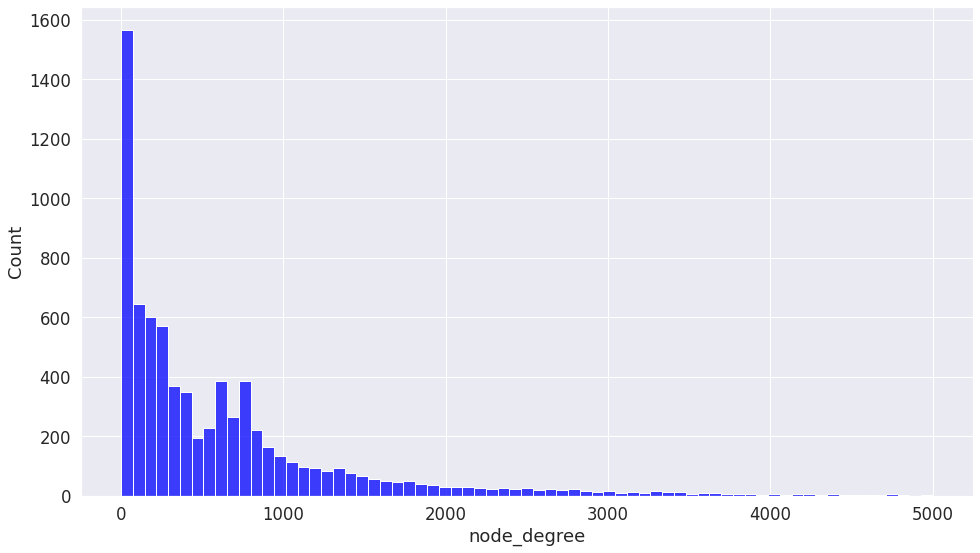

In [ ]:
# Node degree distribution

data = read_query("""
MATCH (u:phsu)
WHERE (u)-[:SIMILAR_NEW]-()
RETURN size((u)-[:SIMILAR_NEW]-()) as node_degree
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.histplot(x="node_degree",data=data, color="blue", binrange=[0,5000])

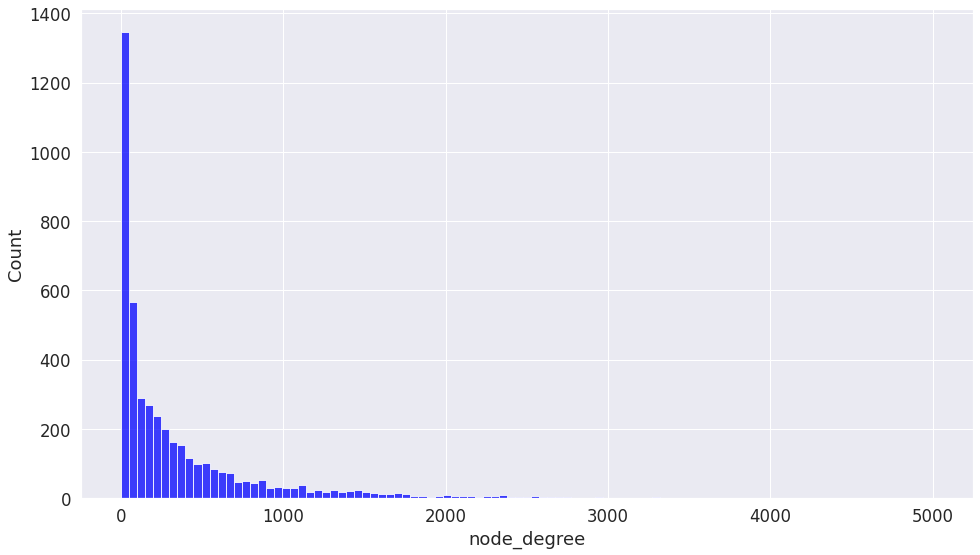

In [ ]:
# Node degree if we look at relationships with weight greater than 1
data = read_query("""
MATCH (u:phsu)-[s:SIMILAR_NEW]-()
WHERE s.weight > 1 
RETURN u, count(*) as node_degree
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.histplot(x="node_degree",data=data, color="blue", binrange=[0,5000])

# Communities with only using relationship weight greater than 1


In [ ]:
# Project the graph
read_query("""
CALL gds.graph.create.cypher("drug",
"MATCH (u:phsu) WHERE (u)-[:SIMILAR_NEW]-() RETURN id(u) as id",
"MATCH (s:phsu)-[r:SIMILAR_NEW]-(t)
 WHERE r.weight > 1
 RETURN id(s) as source, id(t) as target, r.weight as weight")
""")

,nodeQuery,relationshipQuery,graphName,nodeCount,relationshipCount,createMillis
0,MATCH (u:phsu) WHERE (u)-[:SIMILAR_NEW]-() RET...,MATCH (s:phsu)-[r:SIMILAR_NEW]-(t)\n WHERE r.w...,drug,7548,1518372,48962


In [ ]:
# WCC
read_query("""
CALL gds.wcc.stats("drug")
""")['componentDistribution'].to_list()

[{'p99': 1,
  'min': 1,
  'max': 4437,
  'mean': 2.4262295081967213,
  'p90': 1,
  'p50': 1,
  'p999': 1,
  'p95': 1,
  'p75': 1}]

In [ ]:
# Louvain write
read_query("""
CALL gds.louvain.write("drug", {relationshipWeightProperty:"weight", 
  writeProperty:"drug-louvain", includeIntermediateCommunities:true})
""")

,writeMillis,nodePropertiesWritten,modularity,modularities,ranLevels,communityCount,communityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
0,2157,7548,0.166262,"[0.15368850703311226, 0.16626243675615782]",2,3117,"{'p99': 1, 'min': 1, 'max': 2001, 'mean': 2.42...",10,0,6523,"{'maxIterations': 10, 'writeConcurrency': 4, '..."


In [ ]:
# First level
read_query("""
MATCH (u:phsu)
WHERE exists(u.`drug-louvain`)
RETURN u.`drug-louvain`[0] as first_level_community, count(*) as communitySize
ORDER BY communitySize DESC LIMIT 10
""")

,first_level_community,communitySize
0,6470,1545
1,24,977
2,3391,310
3,1096,299
4,1246,258
5,6154,252
6,7292,185
7,1432,168
8,1055,122
9,2416,98


In [ ]:
# investigate first level communities members

read_query("""
MATCH (u:phsu)
WHERE exists(u.`drug-louvain`)
RETURN u.`drug-louvain`[0] as first_level_community, count(*) as communitySize, collect(u.name) as members
ORDER BY communitySize DESC SKIP 2 LIMIT 10
""")['members'][2]

['Procaine',
 'Etodolac',
 'etofenamate',
 'lesinurad',
 'Vitamin K 1',
 'tripterine',
 'glucosamine',
 'raloxifene',
 'polylactic acid-polyglycolic acid copolymer',
 'dinoprostone',
 'alendronate',
 'menatetrenone',
 'benziodarone',
 "3,4-O-isopropylidene-3,3',4,5'-tetrahydroxystilbene",
 'epimedii',
 'methylcellulose',
 'escin',
 'Etidronate',
 'sodium ferulate',
 'human calcitonin',
 'methylprednisolone acetate',
 'tafamidis',
 'cholecalciferol',
 'Ibandronate',
 'Tolmetin',
 'Fluorides',
 'grape seed extract',
 'Emodin',
 'sinapinic acid',
 'Glucosamine Sulfate',
 'tryptophan',
 'Ginsenoside',
 'tocotrienols',
 'risedronate sodium',
 'Endopeptidases',
 'fentiazac',
 'Hydrogel',
 'Calcium + vitamin D',
 'diclofenac sodium',
 'shikonin',
 'rosmarinic acid',
 'Adrenergic alpha-Antagonists',
 'lithium chloride',
 'Diphosphonates',
 'Nitric Oxide Synthase Inhibitor',
 'Cyclooxygenase Inhibitors',
 'dipyrone',
 'piroxicam',
 'Arthrotec',
 'HYLAN G-F 20',
 'Milurite',
 'parthenolide',
 'r

In [ ]:
# Second level
read_query("""
MATCH (u:phsu)
WHERE exists(u.`drug-louvain`)
RETURN u.`drug-louvain`[1] as second_level_community, count(*) as communitySize
ORDER BY communitySize DESC LIMIT 10
""")

,second_level_community,communitySize
0,1432,2001
1,24,977
2,3391,593
3,1096,484
4,1055,353
5,2883,24
6,6470,5
7,3513,2
8,8,1
9,7,1


In [ ]:
read_query("""
CALL gds.graph.drop("drug")
""")

,graphName,database,memoryUsage,sizeInBytes,nodeProjection,relationshipProjection,nodeQuery,relationshipQuery,nodeCount,relationshipCount,density,creationTime,modificationTime,schema
0,drug,semmed43cord19,11709 KiB,11990744,None,None,MATCH (u:phsu)-[s:SIMILAR_NEW]-() WHERE s.weig...,MATCH (s:phsu)-[r:SIMILAR_NEW]-(t)\n WHERE r.w...,4259,827806,0.045647,2021-05-31T08:48:45.571192000+00:00,2021-05-31T08:48:52.981409000+00:00,{'relationships': {'__ALL__': {'weight': 'Floa...


# Communities with only using relationship weight greater than 1
# And ignoring nodes with degree higher than 1500

* 123

In [ ]:
read_query("""
MATCH (u:phsu)-[s:SIMILAR_NEW]-()
WHERE s.weight > 1 
WITH u, count(*) as node_degree
WHERE node_degree > 1500
RETURN u.name as drug
""")['drug'].to_list()

['melatonin',
 'Docosahexaenoic Acids',
 'heparin',
 'Heparin, Low-Molecular-Weight',
 'Erythropoietin',
 'N,N-dimethylarginine',
 'acetylcholine',
 'acetylcysteine',
 'Lactate',
 'carnitine',
 'Active ingredient',
 'human leukocyte interferon',
 'rosuvastatin',
 'cyclosporine',
 'dinoprostone',
 'pioglitazone',
 'Insulin',
 'Vaccines',
 'Amino Acids',
 'cholecalciferol',
 'adrenomedullin',
 'glucose',
 'tryptophan',
 'valproic acid',
 'Endopeptidases',
 'coenzyme Q10',
 'Growth Hormone',
 'colchicine',
 'furosemide',
 'methylprednisolone',
 'cyclophosphamide',
 'Adrenergic alpha-Antagonists',
 'Adrenergic beta-Antagonists',
 'Angiotensin-Converting Enzyme Inhibitors',
 'sildenafil',
 'Antidiabetics',
 'infliximab',
 'resveratrol',
 'cortisone',
 'Angiopoietin-2',
 'angiotensin II',
 'estradiol',
 'atorvastatin',
 'vitamin A',
 'tretinoin',
 'Serotonin Uptake Inhibitors',
 'estrogens',
 'clopidogrel',
 'Biological Products',
 'Biological Response Modifiers',
 'etanercept',
 'Inflammati

In [ ]:
# Project the graph
read_query("""
CALL gds.graph.create.cypher("drug",
"MATCH (u:phsu)-[s:SIMILAR_NEW]-() WHERE s.weight > 1
 WITH u, count(*) as node_degree
 WHERE node_degree < 1500 
 RETURN id(u) as id",
"MATCH (s:phsu)-[r:SIMILAR_NEW]-(t)
 WHERE r.weight > 1
 RETURN id(s) as source, id(t) as target, r.weight as weight",
 {validateRelationships:false})
""")

,nodeQuery,relationshipQuery,graphName,nodeCount,relationshipCount,createMillis
0,MATCH (u:phsu)-[s:SIMILAR_NEW]-() WHERE s.weig...,MATCH (s:phsu)-[r:SIMILAR_NEW]-(t)\n WHERE r.w...,drug,4259,827806,7414


In [ ]:
# WCC
read_query("""
CALL gds.wcc.stats("drug")
""")['componentDistribution'].to_list()

[{'p99': 2,
  'min': 1,
  'max': 4135,
  'mean': 34.90983606557377,
  'p90': 1,
  'p50': 1,
  'p999': 4135,
  'p95': 1,
  'p75': 1}]

In [ ]:
# Louvain write
read_query("""
CALL gds.louvain.write("drug", {relationshipWeightProperty:"weight", 
  writeProperty:"drug_louvain_filtered", includeIntermediateCommunities:true})
""")

,writeMillis,nodePropertiesWritten,modularity,modularities,ranLevels,communityCount,communityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
0,60,4259,0.289003,"[0.27217153414271134, 0.2890032958689275]",2,128,"{'p99': 752, 'min': 1, 'max': 1570, 'mean': 33...",3,0,2365,"{'maxIterations': 10, 'writeConcurrency': 4, '..."


In [ ]:
# First level
read_query("""
MATCH (u:phsu)
WHERE exists(u.`drug_louvain_filtered`)
RETURN u.`drug-louvain`[0] as first_level_community, count(*) as communitySize
ORDER BY communitySize DESC LIMIT 10
""")

,first_level_community,communitySize
0,6470,1480
1,24,911
2,3391,302
3,1096,285
4,6154,247
5,1246,246
6,7292,178
7,1432,168
8,1055,120
9,2416,98


In [ ]:
# Investigate First level community
read_query("""
MATCH (u:phsu)
WHERE exists(u.`drug_louvain_filtered`)
RETURN u.`drug-louvain`[0] as first_level_community, count(*) as communitySize, collect(u.name) as members
ORDER BY communitySize DESC LIMIT 10
""")['members'][5]

['Procaine',
 'Etodolac',
 'etofenamate',
 'lesinurad',
 'Vitamin K 1',
 'tripterine',
 'glucosamine',
 'raloxifene',
 'polylactic acid-polyglycolic acid copolymer',
 'alendronate',
 'menatetrenone',
 'benziodarone',
 "3,4-O-isopropylidene-3,3',4,5'-tetrahydroxystilbene",
 'epimedii',
 'methylcellulose',
 'escin',
 'Etidronate',
 'sodium ferulate',
 'human calcitonin',
 'methylprednisolone acetate',
 'tafamidis',
 'Ibandronate',
 'Tolmetin',
 'Fluorides',
 'grape seed extract',
 'Emodin',
 'sinapinic acid',
 'Glucosamine Sulfate',
 'Ginsenoside',
 'tocotrienols',
 'risedronate sodium',
 'fentiazac',
 'Hydrogel',
 'Calcium + vitamin D',
 'diclofenac sodium',
 'shikonin',
 'rosmarinic acid',
 'lithium chloride',
 'Diphosphonates',
 'Nitric Oxide Synthase Inhibitor',
 'Cyclooxygenase Inhibitors',
 'dipyrone',
 'piroxicam',
 'Arthrotec',
 'HYLAN G-F 20',
 'Milurite',
 'parthenolide',
 'Dexketoprofen',
 'Naproxen sodium',
 'paeonol',
 'Salicin extract',
 'oncostatin M',
 'romosozumab',
 'po

In [ ]:
# Second level
read_query("""
MATCH (u:phsu)
WHERE exists(u.`drug_louvain_filtered`)
RETURN u.`drug-louvain`[1] as second_level_community, count(*) as communitySize
ORDER BY communitySize DESC LIMIT 10
""")

,second_level_community,communitySize
0,1432,1924
1,24,911
2,3391,580
3,1096,463
4,1055,350
5,2883,24
6,6470,5
7,3513,2


In [ ]:
# Find community where is Aspirin